## Environnement setup

In [1]:
import os
import math

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tqdm

In [2]:
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'

In [3]:
import torch

print(f'PyTorch version: {torch.__version__}')
print("GPU found :)" if torch.cuda.is_available() else "No GPU :(")

import torch.nn as nn
import torch.nn.functional as F

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PyTorch version: 1.10.2+cu102
GPU found :)


## Data

In [4]:
from GoDataset import GoDataset
dataset = GoDataset()

Processing dataset:   0%|          | 0/41563 [00:00<?, ? raw/s]

In [5]:
test_rate = 0.02
trainset, testset = dataset.split(test_rate=test_rate)

In [6]:
batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

## Loss and optimizer

In [7]:
class AlphaLoss(torch.nn.Module):
    def __init__(self):
        super(AlphaLoss, self).__init__()
        self.mse = nn.MSELoss(reduction='none')
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, target, policy, value):
        self.value_loss = self.mse(value, target[:,-1:])
        self.policy_loss = self.bce(policy, target[:,:-1])
        return (self.value_loss + self.policy_loss).mean()

In [8]:
import AlphaZeroNet as azn
# Model
net = azn.Net().to(device)

# Binary cross entropy loss and optimizer
criterion = AlphaLoss()

# Optimizer
learning_rate = 0.0002
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

## Model training

In [9]:
history_loss = []
history_value_loss = []
history_policy_loss = []
num_total_epochs = 0
epoch_loss = None

In [72]:
num_epochs = 10
num_total_epochs += num_epochs

step_count = len(trainloader)
savings_per_epoch = 15  # Increase to see more feedback in history

save_threshold = math.ceil(step_count / savings_per_epoch)
last_threshold = step_count % save_threshold

epochs = tqdm.notebook.trange(num_epochs, unit=' epoch', desc='Epoch', postfix=f'loss={epoch_loss}')
pbar = tqdm.notebook.tqdm(total=len(trainloader), unit=' batch', desc='Batch')

for epoch in epochs:
    pbar.reset()
    running_epoch_loss = 0
    running_loss = 0
    running_value_loss = 0
    running_policy_loss = 0
    for i, data in enumerate(trainloader):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        
        # zero the parameter gradients
        net.zero_grad()
        
        # foraward
        policies, values = net(inputs)
        
        # backward
        loss = criterion(targets, policies, values)
        loss.backward()
        
        # optimize
        optimizer.step()
        
        loss_item = loss.item()
        value_loss_item = criterion.value_loss.mean().item()
        policy_loss_item = criterion.policy_loss.mean().item()
        
        # progress bar
        pbar.set_postfix({"batch_loss": loss_item, "value_loss": value_loss_item, "policy_loss": policy_loss_item})
        pbar.update()
        
        # Save losses at regular intervals
        running_epoch_loss += loss_item
        running_loss += loss_item
        running_value_loss += value_loss_item
        running_policy_loss += policy_loss_item
        
        
        if (i + 1) % save_threshold == 0:
            history_loss.append(running_loss/save_threshold)
            history_value_loss.append(running_value_loss/save_threshold)
            history_policy_loss.append(running_policy_loss/save_threshold)
            running_loss = 0
            running_value_loss = 0
            running_policy_loss = 0
        elif (i + 1) == step_count:
            history_loss.append(running_loss/last_threshold)
            history_value_loss.append(running_value_loss/last_threshold)
            history_policy_loss.append(running_policy_loss/last_threshold)
            running_loss = 0
            running_value_loss = 0
            running_policy_loss = 0
    epoch_loss = running_epoch_loss/step_count
    epochs.set_postfix({"loss": epoch_loss})
        
pbar.close()
epochs.close()

Epoch:   0%|          | 0/10 [00:00<?, ? epoch/s, loss=0.010412508406553347]

Batch:   0%|          | 0/318 [00:00<?, ? batch/s]

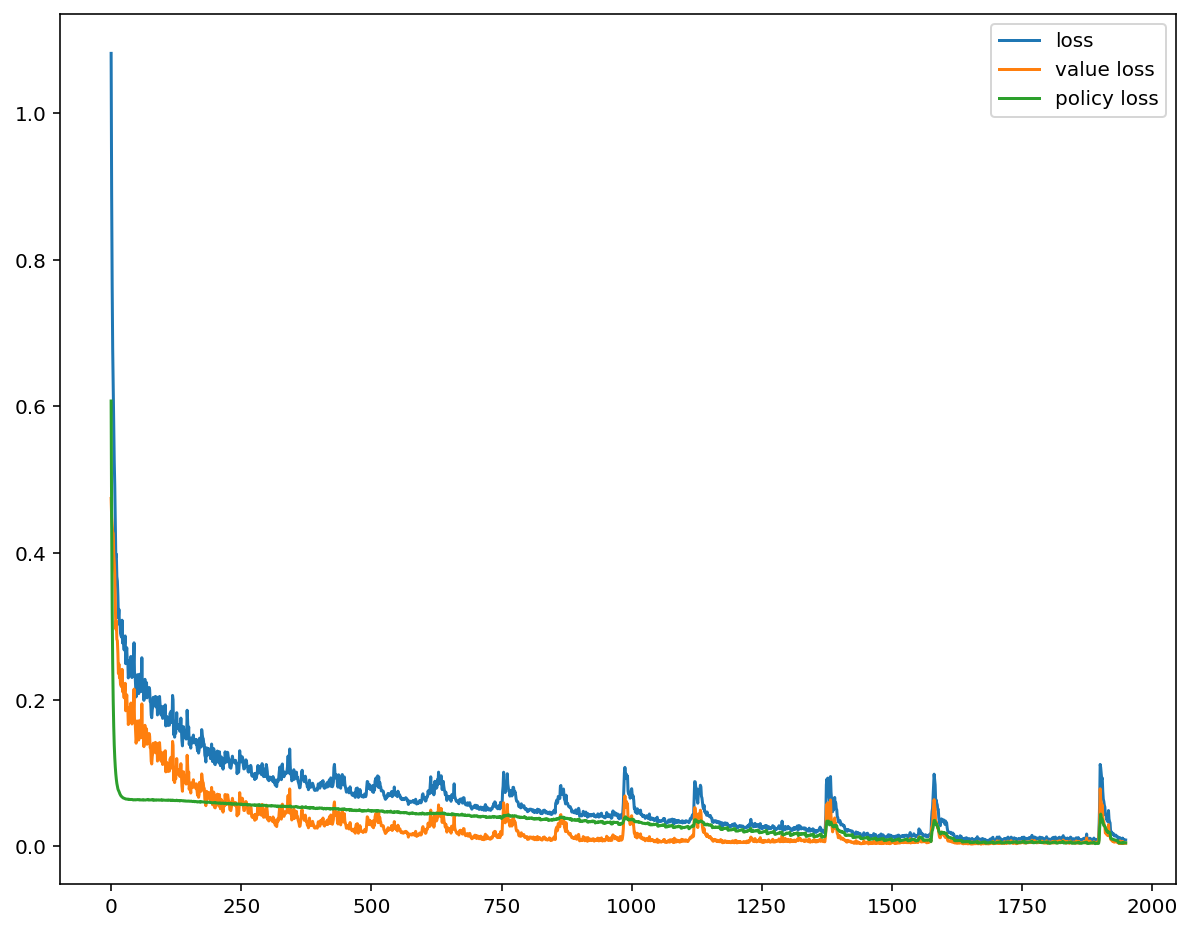

In [73]:
plt.plot(np.arange(len(history_loss)), history_loss)
plt.plot(np.arange(len(history_loss)), history_value_loss)
plt.plot(np.arange(len(history_loss)), history_policy_loss)
plt.legend(["loss", "value loss", "policy loss"])

## Test

In [74]:
with torch.no_grad():
    net.eval()
    running_loss = 0
    running_value_loss = 0
    running_policy_loss = 0
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)
        policies, values = net(inputs)
        running_loss += criterion(targets, policies, values).item()
        running_value_loss += criterion.value_loss.mean().item()
        running_policy_loss += criterion.policy_loss.mean().item()
    
    net.train()
print(f"num_epoch: {num_total_epochs}, loss: {running_loss/len(testloader)}, value_loss: {running_value_loss/len(testloader)}, policy_loss: {running_policy_loss/len(testloader)}")

num_epoch: 130, loss: 0.30153615134102957, value_loss: 0.19263808216367448, policy_loss: 0.10889806598424911


## Save

In [75]:
torch.save(net.state_dict(), f"model/model_{num_total_epochs}.pt")

## Checkpoint comparison

In [77]:
def load_and_test(num):
    test_net = azn.Net().to(device)
    test_net.load_state_dict(torch.load(f"model/model_{num}.pt"))
    with torch.no_grad():
        test_net.eval()
        running_loss = 0
        running_value_loss = 0
        running_policy_loss = 0
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            policies, values = test_net(inputs)
            running_loss += criterion(targets, policies, values).item()
            running_value_loss += criterion.value_loss.mean().item()
            running_policy_loss += criterion.policy_loss.mean().item()
    return running_loss/len(testloader), running_value_loss/len(testloader), running_policy_loss/len(testloader)

In [78]:
num_models = [(i+1)*10 for i in range(13)]

losses = []
value_losses = []
policy_losses = []

for num in num_models:
    loss, value_loss, policy_loss = load_and_test(num)
    losses.append(loss)
    value_losses.append(value_loss)
    policy_losses.append(policy_loss)

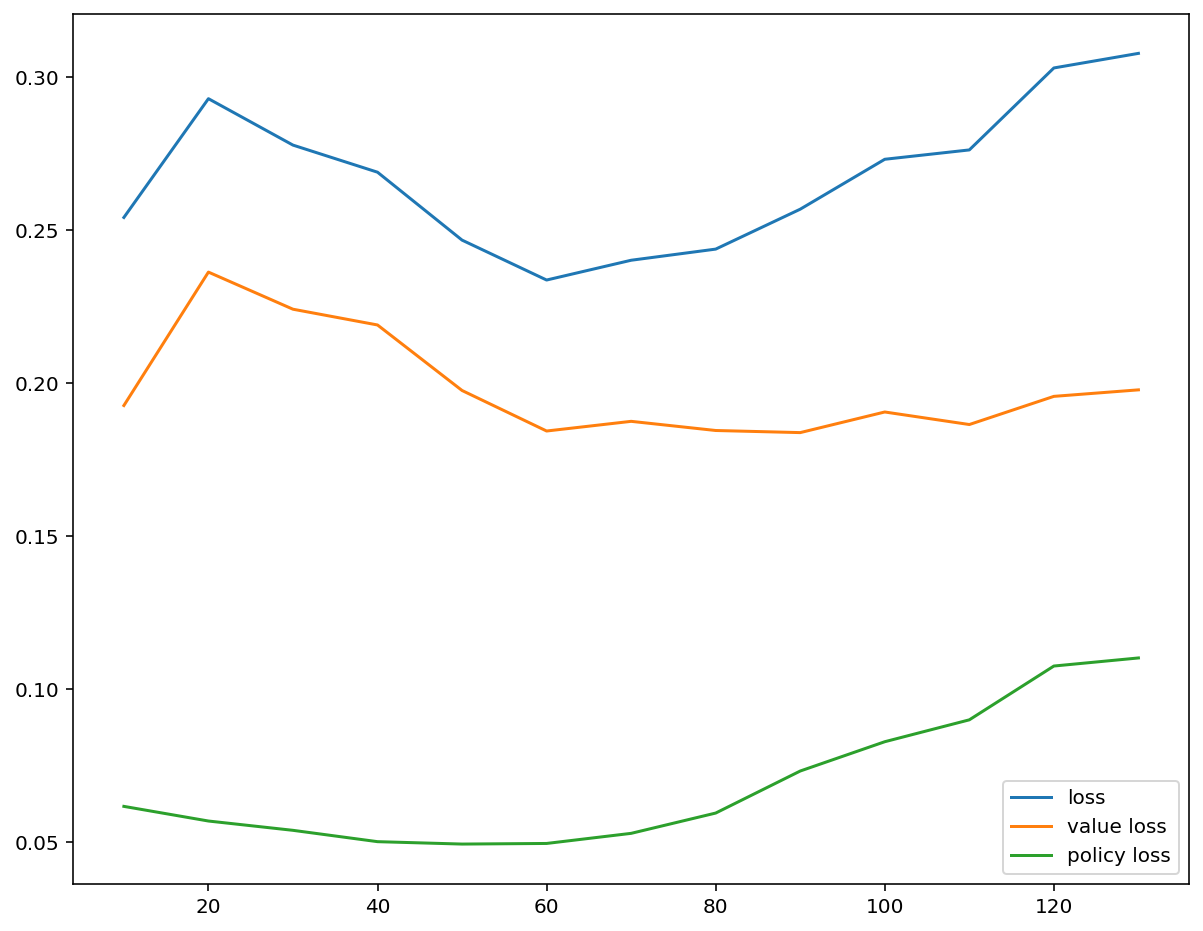

In [79]:
plt.plot(num_models, losses)
plt.plot(num_models, value_losses)
plt.plot(num_models, policy_losses)
plt.legend(["loss", "value loss", "policy loss"])

Il faut prendre le 60